In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import absolute_import, division, print_function

%matplotlib inline
%connect_info

/Users/hkwik/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


{
  "stdin_port": 59978, 
  "ip": "127.0.0.1", 
  "control_port": 59979, 
  "hb_port": 59980, 
  "signature_scheme": "hmac-sha256", 
  "key": "774d19a8-c666-424a-87f9-accc68f1faf5", 
  "kernel_name": "", 
  "shell_port": 59976, 
  "transport": "tcp", 
  "iopub_port": 59977
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /Users/hkwik/Library/Jupyter/runtime/kernel-8c246750-a84c-4955-9cc6-784dca83f1bd.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [4]:
date_chunks = pd.read_csv("data/train_date.csv", index_col=0, chunksize=100000, dtype=np.float32)
num_chunks = pd.read_csv("data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=100000, dtype=np.float32)

In [5]:
X = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05, random_state=24)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y = pd.read_csv("data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()


In [6]:
clf = XGBClassifier(base_score=0.005, seed=24)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=24, silent=True, subsample=1)

[  34  831  939 1018 1019 1029 1034 1159 1168 1169 1177 1180 1182 1183 1186
 1188 1190 1191 1210 1228 1236 1249 1250 1258 1261 1267 1270 1274 1282 1283
 1288 1297 1306 1468 1483 1487 1516 1549 1550 1551 1838 1846 1847 1851 1876
 1880 1886 1888 1889 1890 1892 1899 1911 1914 1927 1932 1934 1940 1942 1944
 1954 1955 1958 1960 1970 1982 1983 1984 1985 1987 1988 2004 2006 2007 2020
 2022 2038 2040 2060 2093]


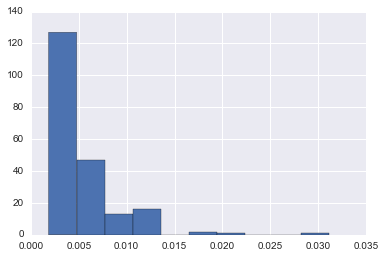

In [7]:
#### threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [ ]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values,
    pd.read_csv("data/fail_date_score.csv", index_col=0, header=None, dtype=np.float32).values
], axis=1)

y = pd.read_csv("data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [ ]:
clf = XGBClassifier(max_depth=5, base_score=0.005, seed=24)
cv = StratifiedKFold(y, n_folds=3, random_state=24)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

In [ ]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [ ]:
# load test data
X = np.concatenate([
    pd.read_csv("data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values,
    pd.read_csv("fail_date_score_test.csv", index_col=0, header=None, dtype=np.float32).values
], axis=1)

In [ ]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [ ]:
# and submit
sub = pd.read_csv("data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")

NameError: name 'sub' is not defined